In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import datetime as dt
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.sparse as sparse
import numpy as np
import apyori
from apyori import apriori
import lightfm
from lightfm import LightFM
from lightfm.evaluation import reciprocal_rank, auc_score, precision_at_k
#!pip install apyori
#!pip install lightfm
#!pip install algorithms
import warnings
warnings.filterwarnings('ignore')

print("Pandas version " + pd.__version__)
print("Seaborn version " + sns.__version__)
print("Matplotlib version " + matplotlib.__version__)
print("Numpy version " + np.__version__)
print("Apriori version " + apyori.__version__)
print("Lightfm version " + lightfm.__version__)

Pandas version 0.23.2
Seaborn version 0.9.0
Matplotlib version 2.2.2
Numpy version 1.14.5
Apriori version 1.1.1
Lightfm version 1.15


/anaconda3/envs/MaskRCNN/lib/python3.6/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
data1 = pd.read_csv("test dataset.csv", sep = ";")
data = pd.read_csv("dataset for test new.csv", sep = ";")

for_prediction = data[data["ar_id"].isnull()]
data = data[~data["ar_id"].isnull()]

In [3]:
data.shape

(48273, 6)

We have an information about clients' purchases till 31.07.2008.
Our variables are:
1. ***dt*** - time of the purchase

2. ***tr_id*** -  unique number of purchase

3. ***cl_id*** - unique number of client

4. ***ar_id*** - unique number of item

5. ***qty*** - quality of the items bought

6. ***s*** - purchase price for this item

In [4]:
data.head()

,dt,tr_id,cl_id,ar_id,qty,s
0,2007-05-03 21:43:33,954,1,2874.0,1.0,8150.0
1,2007-11-20 20:46:41,13796,1,3586.0,1.0,3930.0
2,2007-12-08 16:28:59,14431,1,4942.0,1.0,2860.0
3,2007-05-03 21:15:59,951,2,2812.0,1.0,4895.0
4,2007-05-20 16:46:45,3352,2,5025.0,1.0,840.0


In [5]:
data.dtypes

dt        object
tr_id      int64
cl_id      int64
ar_id    float64
qty      float64
s        float64
dtype: object

In [6]:
data["dt"] = pd.to_datetime(data["dt"])
data['qty'] = data['qty'].astype(int)

In [7]:
print(data.shape)
print(data.isnull().sum())

(48273, 6)
dt       0
tr_id    0
cl_id    0
ar_id    0
qty      0
s        0
dtype: int64


In [8]:
#check the duplicates
#data[data.duplicated(['tr_id', 'cl_id', 'ar_id', 'qty', 's'], keep = False)]

# Gatting rid of duplicates
data = data.drop_duplicates(subset = None, keep = 'first', inplace = False)

In [9]:
data.shape

(47146, 6)

In [10]:
# I have noticed that some transaction ids have several client ids. 
# So I thought it might be bacause the data came from retail chain and 
# each branch has it's ows transaction history. Thus I decided to create
# a global id amongs the whole system to make it unique.
#data = data.sort_values(by = ['tr_id'])
#data['global_tr_id'] = data['tr_id']

#last = max(data["tr_id"])
#for i in range(1, len(data)):
#    data.iloc[i]['global_tr_id'] = data.iloc[i]['tr_id']
#    
#    if data.iloc[i]['tr_id'] == data.iloc[i - 1]['tr_id'] and (data.iloc[i]['dt'] != data.iloc[i - 1]['dt'] or data.iloc[i]['cl_id'] != data.iloc[i - 1]['cl_id']):
#        data.iloc[i]['global_tr_id'] = last + 1
#        last = last + 1
#    else:
#        data.iloc[i]['global_tr_id'] = data.iloc[i - 1]['global_tr_id']
#    print(data.iloc[i])

# Descriptive Statistics

In [11]:
data[['qty', 's']].describe()

,qty,s
count,47146.0,47146.000000
mean,1.0,10455.257645
std,0.0,12701.269894
min,1.0,504.000000
25%,1.0,3810.000000
50%,1.0,6910.000000
75%,1.0,12750.000000
max,1.0,511500.000000


In [12]:
#Checking data for negative values
data.min()

dt       2007-03-12 18:50:49
tr_id                      1
cl_id                      1
ar_id                      1
qty                        1
s                        504
dtype: object

In [13]:
#What is the average purchase price?
data['s'].mean()

10455.25764455097

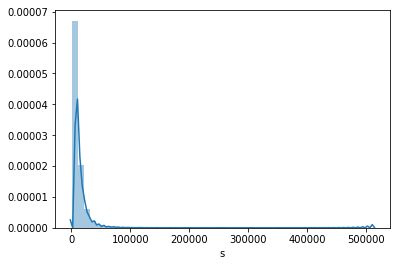

In [14]:
ax = sns.distplot(data["s"].astype(int))

In [15]:
data['date'] = data['dt'].dt.date
data2 = data[['s', 'date']].groupby("date").sum().sort_values("date", ascending = True)
data2.reset_index(drop = False, inplace = True)

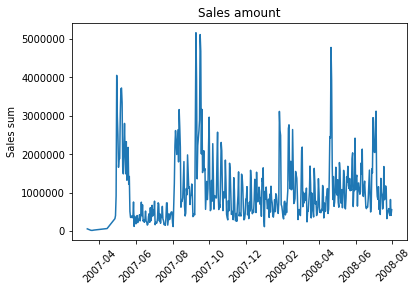

In [16]:
plt.plot(data2["date"], data2['s'])
plt.title('Sales amount')
plt.ylabel('Sales sum')
plt.xticks(rotation = 45)
plt.show()

In [17]:
data2 = data[['s', 'date']].groupby("date").count().sort_values("date", ascending = True)
data2.reset_index(drop = False, inplace = True)

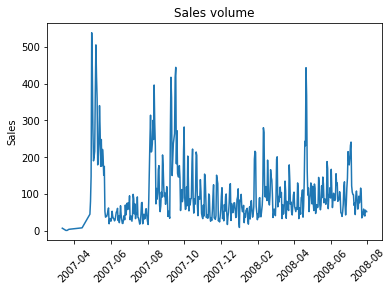

In [18]:
plt.plot(data2["date"], data2['s'])
plt.title('Sales volume')
plt.ylabel('Sales')
plt.xticks(rotation = 45)
plt.show()

Text(0.5,1,'Purshases frequency by hour')

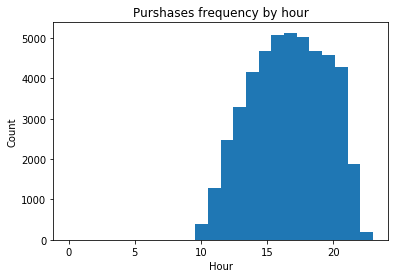

In [19]:
plt.hist(data['dt'].dt.hour.values, bins=24)
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Purshases frequency by hour')
# I guess it works from 10am to 11pm

In [20]:
# Show most profitable items across the time
profitability = data[['ar_id', 'qty', 's']].groupby("ar_id").sum().sort_values("s", ascending = False)
profitability.head()

,qty,s
ar_id,,
3060.0,156,7114347.53
4757.0,281,6684277.87
4944.0,725,5092324.27
3487.0,435,4566229.85
2430.0,94,3805189.37


In [21]:
# Show most popular items across the time
popularity = data[['ar_id', 'qty', 's']].groupby("ar_id").sum().sort_values("qty", ascending = False)
popularity.head()

,qty,s
ar_id,,
4944.0,725,5092324.27
4911.0,580,1823693.31
3487.0,435,4566229.85
434.0,430,1747247.86
2635.0,425,1211674.74


In [22]:
#data.reset_index(drop = True, inplace = True)
time = data[['dt', 's']]
time.set_index('dt', inplace = True)
time.head()

,s
dt,
2007-05-03 21:43:33,8150.0
2007-11-20 20:46:41,3930.0
2007-12-08 16:28:59,2860.0
2007-05-03 21:15:59,4895.0
2007-05-20 16:46:45,840.0


In [23]:
# See the example of report
time.resample('M').sum().head(5)

,s
dt,
2007-03-31,101833.00
2007-04-30,5743184.76
2007-05-31,50490424.16
2007-06-30,10875458.70
2007-07-31,11919265.63


## ABC analysis
ABC analysis is an inventory categorization method which consists in dividing items into three categories (A, B, C): 
* A being the most valuable items,
* C being the least valuable ones.

20% of items accounts for 80% of firms expenditure
### What to do with this groups:
<table>
<tr><td>** Class **</td><td>** Percentage of items **</td><td>** Percentage value of annual sales **</td><td>** Action **</td></tr>
<tr><td>A</td><td>About 20%</td><td>About 80%</td><td>Close day to day control</td></tr>
<tr><td>B</td><td>About 30%</td><td>About 15%</td><td>Regular review</td></tr>
<tr><td>C</td><td>About 50%</td><td>About 5%</td><td>Infrequent review</td></tr>
</table>

In [24]:
abc = data.groupby(['ar_id'])['qty', 's'].sum()
abc.reset_index(drop = False, inplace = True)
#abc = abc.drop_duplicates(subset = None, keep = 'first', inplace = False)

In [25]:
abc['share_sales'] = abc['s'] / abc['s'].sum() * 100
abc['share_items'] = abc['qty'] / abc['qty'].sum() * 100

In [26]:
# Looking at our top customers
abc = abc.sort_values('share_sales', ascending = False)
abc['cum_sales'] = abc['share_sales'].cumsum()

abc = abc.sort_values('share_items', ascending = False)
abc['cum_items'] = abc['share_items'].cumsum()

In [27]:
abc.head()

,ar_id,qty,s,share_sales,share_items,cum_sales,cum_items
4744,4944.0,725,5092324.27,1.033086,1.537776,3.832430,1.537776
4714,4911.0,580,1823693.31,0.369975,1.230221,13.936921,2.767997
3366,3487.0,435,4566229.85,0.926357,0.922666,4.758786,3.690663
417,434.0,430,1747247.86,0.354466,0.912060,14.291388,4.602723
2542,2635.0,425,1211674.74,0.245814,0.901455,24.168217,5.504179


In [28]:
abc.shape

(5293, 7)

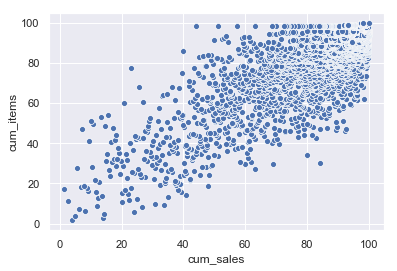

In [29]:
sns.set()
ax = sns.scatterplot(x = "cum_sales", y = "cum_items", data = abc)
#plt.savefig('Cumulative_plot.png')
plt.show()

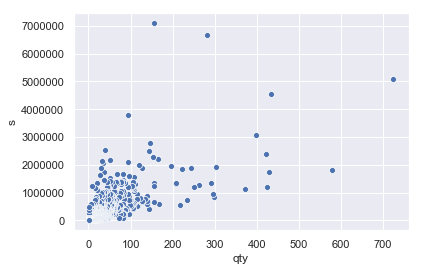

In [30]:
sns.set()
ax = sns.scatterplot(x = "qty", y = "s", data = abc)
#plt.savefig('Sales.png')
plt.show()

Since it is not clear that ABC (3 groups) will fit perfectly to our cluster, we will try to cluster data automatically fisrt, using k-means.

In [31]:
Sum_of_squared_distances = []
K = range(1, 20)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(abc[["qty", "s"]])
    Sum_of_squared_distances.append(km.inertia_)

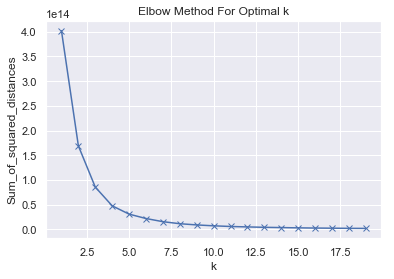

In [32]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [33]:
#In the plot above the elbow is at k = 5 indicating the optimal k for this dataset is 5
kmeans = KMeans(n_clusters = 5, random_state=0).fit(abc[["qty", "s"]])

predict = kmeans.predict(abc[["qty", "s"]])
abc['cluster'] = predict
abc.head()

,ar_id,qty,s,share_sales,share_items,cum_sales,cum_items,cluster
4744,4944.0,725,5092324.27,1.033086,1.537776,3.832430,1.537776,2
4714,4911.0,580,1823693.31,0.369975,1.230221,13.936921,2.767997,4
3366,3487.0,435,4566229.85,0.926357,0.922666,4.758786,3.690663,2
417,434.0,430,1747247.86,0.354466,0.912060,14.291388,4.602723,4
2542,2635.0,425,1211674.74,0.245814,0.901455,24.168217,5.504179,1


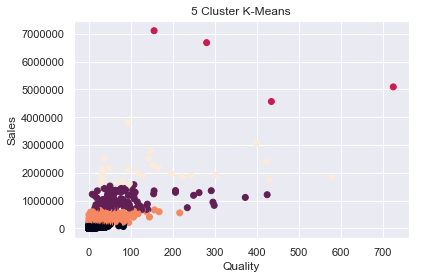

In [34]:
plt.figure('5 Cluster K-Means')
plt.scatter(abc['qty'], abc["s"], c = kmeans.labels_)
plt.xlabel('Quality')
plt.ylabel('Sales')
plt.title('5 Cluster K-Means')
#plt.savefig('k-means_sales.png')
plt.show()

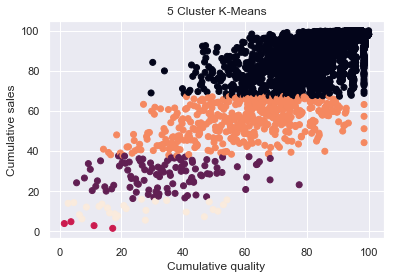

In [35]:
plt.figure('5 Cluster K-Means')
plt.scatter(abc['cum_items'], abc["cum_sales"], c = kmeans.labels_)
plt.xlabel('Cumulative quality')
plt.ylabel('Cumulative sales')
plt.title('5 Cluster K-Means')
#plt.savefig('k-means_cumulative.png')
plt.show()

## RFM analysis
A customer segmentation technique that uses past purchase behavior to segment customers.
1. Recency (R) - Time since last purchase 
2. Frequency (F) - Total number of purchases 
3. Monetary value (M) - Total monetary value 


Benefits of RFM analysis

* Increased customer retention
* Increased response rate
* Increased conversion rate
* Increased revenue

In [36]:
rfm = data.groupby(['tr_id'])['qty', 's'].sum()
rfm.reset_index(drop = False, inplace = True)
rfm = pd.merge(rfm, data[['cl_id', 'dt', 'tr_id']], how = 'inner', on = 'tr_id')
rfm = rfm.drop_duplicates(subset = None, keep = 'first', inplace = False)

In [37]:
rfm.head()

,tr_id,qty,s,cl_id,dt
0,1,2,21365.0,4526,2007-03-12 18:50:49
2,2,2,16423.0,4526,2007-03-12 18:52:29
4,3,2,10915.0,4526,2007-03-12 18:54:39
6,4,1,4495.0,4526,2007-03-12 18:56:35
7,5,1,15050.0,2637,2007-03-18 17:26:00


In [38]:
NOW = dt.datetime(2008, 8, 1) # the last day in our data

rfm = rfm.groupby('cl_id').agg({'dt': lambda x: (NOW - x.max()).days, # Recency
                                        'tr_id': lambda x: len(x),         # Frequency
                                        's': lambda x: x.sum()})           # Monetary Value

rfm['dt'] = rfm['dt'].astype(int)
rfm.rename(columns = {'dt': 'recency', 
                    'tr_id': 'frequency', 
                    's': 'monetary_value'}, inplace=True)

# Example: customer 1 has frequency: 3, monetary value: $14940 and recency: 235 days
rfm.head()

,recency,frequency,monetary_value
cl_id,,,
1,236,3,14940.0
2,76,4,88540.0
3,455,1,7100.0
4,8,26,351196.5
5,453,1,3035.0


### Determining RFM Quartiles

In [39]:
quantiles = rfm.quantile(q = [0.25,0.5,0.75]).to_dict()
quantiles

{'recency': {0.25: 83.0, 0.5: 185.0, 0.75: 334.0},
 'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'monetary_value': {0.25: 7490.0, 0.5: 17545.0, 0.75: 41490.0}}

In [40]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
# Creating the RFM segmentation table
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [41]:
rfm['R_Quartile'] = rfm['recency'].apply(RClass, args = ('recency', quantiles,))
rfm['F_Quartile'] = rfm['frequency'].apply(FMClass, args = ('frequency', quantiles,))
rfm['M_Quartile'] = rfm['monetary_value'].apply(FMClass, args = ('monetary_value', quantiles,))

rfm['RFMClass'] = rfm.R_Quartile.map(str) + rfm.F_Quartile.map(str) + rfm.M_Quartile.map(str)
#frm.to_csv('rfm-table.csv', sep=',')
rfm.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
cl_id,,,,,,,
1,236,3,14940.0,3,1,3,313
2,76,4,88540.0,1,1,1,111
3,455,1,7100.0,4,4,4,444
4,8,26,351196.5,1,1,1,111
5,453,1,3035.0,4,4,4,444


In [42]:
#Who are the top 5 best customers? by RFM Class (111), high spenders who buy recently and frequently?
rfm[rfm['RFMClass'] == '111'].sort_values('monetary_value', ascending = False).head(5)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
cl_id,,,,,,,
1572,0,126,6300874.84,1,1,1,111
2177,12,44,3716194.39,1,1,1,111
4997,66,35,3012222.70,1,1,1,111
3738,0,128,2694385.00,1,1,1,111
3799,7,95,2493029.97,1,1,1,111


### What to do with this segments:
<table>
<tr><td>** Segment **</td><td>** RFM **</td><td>** Description **</td><td>** Marketing **</td></tr>
<tr><td>Best Customers</td><td>111</td><td>Customers who bought most recently, most often and spend the most.</td><td>No price incentives, New products and loyalty programs</td></tr>
<tr><td>Loyal Customers</td><td>X1X</td><td>Customers who bought most recently</td><td>Use R and M to further segment.</td></tr>
<tr><td>Big Spenders</td><td>XX1</td><td>Customers who spend the most</td><td>Market your most expensive products.</td></tr>
<tr><td>Almost Lost</td><td>311</td><td>Haven't purchased for some time, but purchased frequently and spend the most.</td><td>Agressive price incentives</td></tr>
<tr><td>Lost Customers</td><td>411</td><td>Haven't purchased for some time, but purchased frequently and spend the most.</td><td>Agressive price incentives.</td></tr>
<tr><td>Lost Cheap Customers</td><td>444</td><td>Last purchase long ago, purchased few and spend little.</td><td>Don't spend too much trying to re-acquire.</td></tr>
<tr><td>...</td><td>...</td><td>...</td><td>...</td></tr>
</table>

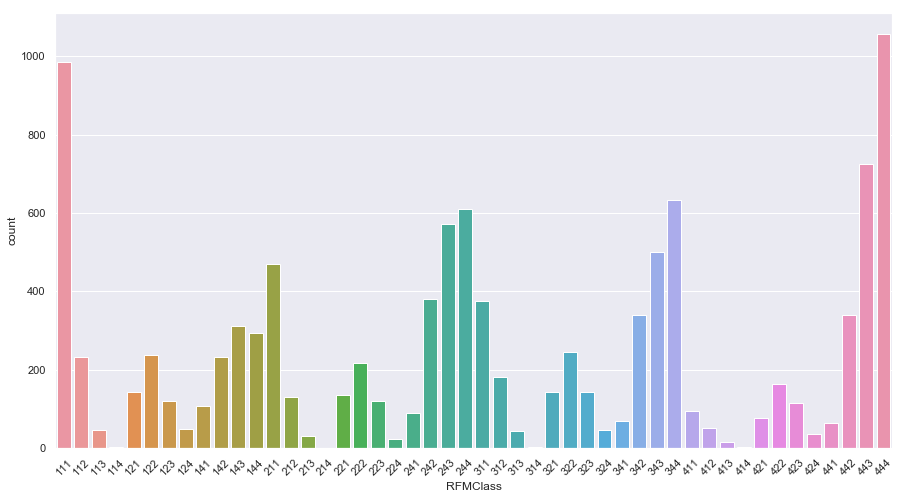

In [43]:
plt.figure(figsize=(15, 8))
sns.set()
ax = sns.countplot(x = "RFMClass", data = rfm)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

## Association Rule Mining via Apriori Algorithm

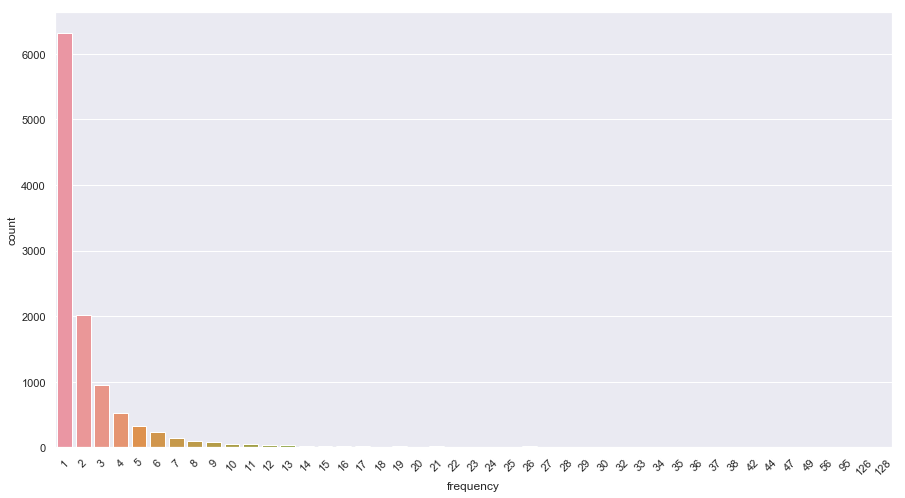

In [44]:
# Let's look at our distribution of 
plt.figure(figsize=(15, 8))
sns.set()
ax = sns.countplot(x = "frequency", data = rfm)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

In [45]:
a = data['ar_id'].value_counts()
print(type(a))

<class 'pandas.core.series.Series'>


In [46]:
a

4944.0    725
4911.0    580
3487.0    435
434.0     430
2635.0    425
5064.0    423
5019.0    399
4942.0    373
2715.0    303
5049.0    299
471.0     296
5125.0    292
4757.0    281
2812.0    263
2892.0    250
5084.0    244
359.0     235
2839.0    223
443.0     217
2366.0    207
2699.0    207
4945.0    197
308.0     168
4801.0    166
5076.0    157
4918.0    156
3060.0    156
5305.0    155
2519.0    153
4803.0    147
         ... 
3562.0      1
5405.0      1
1016.0      1
2972.0      1
4012.0      1
4424.0      1
4348.0      1
1853.0      1
3212.0      1
4790.0      1
2963.0      1
1511.0      1
4259.0      1
5421.0      1
2174.0      1
738.0       1
572.0       1
3526.0      1
1857.0      1
5354.0      1
5372.0      1
5253.0      1
2990.0      1
1499.0      1
2915.0      1
2749.0      1
1345.0      1
4666.0      1
1196.0      1
3765.0      1
Name: ar_id, Length: 5293, dtype: int64

In [47]:
apriori = data.groupby('tr_id')['ar_id'].apply(lambda g: g.values.tolist()).to_dict()
apriori = list(apriori.values())

# Maximum items in a basket
max(len(elem) for elem in apriori)

27

In [48]:
transactions = []
for i in range(0, len(apriori)):
    n = list(apriori[i])
    for x in range(27):
        n = np.append(n, 'nan')
    transactions.append(n.tolist())

But usually you want all three to be high.
* high support: should apply to a large amount of cases
* high confidence: should be correct often
* high lift: indicates it is not just a coincidence

In [49]:
# training Apriori on the dataset
from apyori import apriori
rules = apriori(transactions, min_support = 0.001, min_confidence = 0.01, min_lift = 3, min_length = 2)

# Visualising the results
list(rules)

[RelationRecord(items=frozenset({'2812.0', '2635.0'}), support=0.0010992759940866533, ordered_statistics=[OrderedStatistic(items_base=frozenset({'2635.0'}), items_add=frozenset({'2812.0'}), confidence=0.07455012853470437, lift=8.160609713170274), OrderedStatistic(items_base=frozenset({'2812.0'}), items_add=frozenset({'2635.0'}), confidence=0.1203319502074689, lift=8.160609713170276)]),
 RelationRecord(items=frozenset({'443.0', '434.0'}), support=0.001288806337894697, ordered_statistics=[OrderedStatistic(items_base=frozenset({'434.0'}), items_add=frozenset({'443.0'}), confidence=0.10725552050473186, lift=17.684424290220818), OrderedStatistic(items_base=frozenset({'443.0'}), items_add=frozenset({'434.0'}), confidence=0.2125, lift=17.684424290220818)]),
 RelationRecord(items=frozenset({'434.0', '471.0'}), support=0.0015541488192259581, ordered_statistics=[OrderedStatistic(items_base=frozenset({'434.0'}), items_add=frozenset({'471.0'}), confidence=0.12933753943217666, lift=14.3363597805052

With relatively big dataset and loyal rules, there are not enought interconnections in our data to create reasonable amount of product suggestions - just 5.

## Recommendations

In [50]:
all_user_items = data[['ar_id', 'cl_id']]
all_user_items.columns = ['item','user']
all_user_items['weight'] = 1
all_user_items.head()

,item,user,weight
0,2874.0,1,1
1,3586.0,1,1
2,4942.0,1,1
3,2812.0,2,1
4,5025.0,2,1


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
#tf = TfidfVectorizer(min_df=0)
vec = TfidfVectorizer()

beerlist_tfidf = vec.fit_transform(all_user_items['item'].astype(str)).toarray()
#beer_tfidf = vec.transform(['heinekin lager']).toarray()
#tfidf_matrix = tf.fit_transform(all_user_items['item'])


In [52]:
beerlist_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
last_item_id = all_user_items["item"].max()
last_user_id = all_user_items["user"].max()

In [54]:
from scipy.sparse import csr_matrix

user_with_item = all_user_items[["user", "item"]].as_matrix()
user_item_matrix = csr_matrix((all_user_items["weight"].tolist(), ([both[0] for both in user_with_item],
            [both[1] for both in user_with_item],)), shape = (last_user_id + 1, last_item_id + 1), dtype = np.float32)

In [55]:
np.random.seed(0)
test_indices = np.random.choice(range(user_item_matrix.nnz), replace = False, size = int(user_item_matrix.nnz * 0.2)).tolist()

In [56]:
train = user_item_matrix.copy()
train.data[test_indices] = 0
train.eliminate_zeros()

test = user_item_matrix.copy()
test.data[:] = 0
test.data[test_indices] = user_item_matrix.data[test_indices]
test.eliminate_zeros()

In [57]:
train

<11051x5524 sparse matrix of type '<class 'numpy.float32'>'
	with 33096 stored elements in Compressed Sparse Row format>

In [58]:
alpha = 1e-05
epochs = 15
num_components = 32

warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=alpha,
                    item_alpha=alpha)

bpr_model = LightFM(no_components=num_components,
                    loss='bpr',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

logistic_model = LightFM(no_components=30,
                        loss='logistic', 
                        learning_schedule='adadelta',
                        user_alpha=alpha, item_alpha=alpha)

warp_auc = []
warp_test_auc = []
bpr_auc = []
bpr_test_auc = []
logistic_auc = []
logistic_test_auc = []

for epoch in range(epochs):
    warp_model.fit_partial(train, epochs = 1)
    warp_auc.append(auc_score(warp_model, train,).mean())
    warp_test_auc.append(auc_score(warp_model, test).mean())
    
for epoch in range(epochs):
    bpr_model.fit_partial(train, epochs = 1)
    bpr_auc.append(auc_score(bpr_model, train).mean())
    bpr_test_auc.append(auc_score(bpr_model, test).mean())

for epoch in range(epochs):
    logistic_model.fit_partial(train, epochs = 1)
    logistic_auc.append(auc_score(logistic_model, train).mean())
    logistic_test_auc.append(auc_score(logistic_model, test).mean())

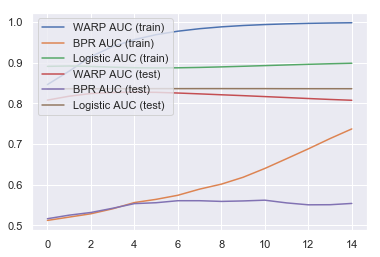

In [59]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.plot(x, np.array(logistic_auc))
plt.plot(x, np.array(warp_test_auc))
plt.plot(x, np.array(bpr_test_auc))
plt.plot(x, np.array(logistic_test_auc))
plt.legend(['WARP AUC (train)', 'BPR AUC (train)', 'Logistic AUC (train)', 'WARP AUC (test)', 'BPR AUC (test)', 'Logistic AUC (test)'], loc = 'upper left')
plt.show()

In [60]:
alpha = 1e-3
epochs = 15

adagrad_model = LightFM(no_components=30,
                        loss='warp-kos', 
                        learning_schedule='adagrad',
                        user_alpha=alpha, item_alpha=alpha)

adadelta_model = LightFM(no_components=30,
                        loss='warp-kos', 
                        learning_schedule='adadelta',
                        user_alpha=alpha, item_alpha=alpha)

adagrad_auc = []
adagrad_test_auc = []
adadelta_auc = []
adadelta_test_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, train).mean())
    adagrad_test_auc.append(auc_score(adagrad_model, test).mean())

for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, train).mean())
    adadelta_test_auc.append(auc_score(adadelta_model, test).mean())

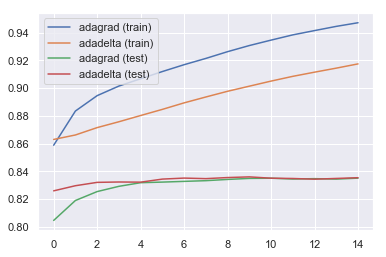

In [61]:
x = np.arange(epochs)
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.plot(x, np.array(adagrad_test_auc))
plt.plot(x, np.array(adadelta_test_auc))
plt.legend(['adagrad (train)', 'adadelta (train)', 'adagrad (test)', 'adadelta (test)'], loc = 'upper left')
plt.show()

In [62]:
print("Train WARP AUC: %.2f" % pd.Series(warp_auc).mean())
print("Test WARP AUC: %.2f" % pd.Series(warp_test_auc).mean())
print('   ')
print("Train BPR AUC: %.2f" % pd.Series(bpr_auc).mean())
print("Test BPR AUC: %.2f" % pd.Series(bpr_test_auc).mean())
print('   ')
print("Train logistic AUC: %.2f" % pd.Series(logistic_auc).mean())
print("Test logistic AUC: %.2f" % pd.Series(logistic_test_auc).mean())
print('   ')
print("Train WARP + adagrad AUC: %.2f" % pd.Series(adagrad_auc).mean())
print("Test WARP + adagrad AUC: %.2f" % pd.Series(adagrad_test_auc).mean())
print('   ')
print("Train WARP + adadelta AUC: %.2f" % pd.Series(adadelta_auc).mean())
print("Test WARP + adadelta AUC: %.2f" % pd.Series(adadelta_test_auc).mean())

Train WARP AUC: 0.96
Test WARP AUC: 0.82
   
Train BPR AUC: 0.60
Test BPR AUC: 0.55
   
Train logistic AUC: 0.89
Test logistic AUC: 0.84
   
Train WARP + adagrad AUC: 0.92
Test WARP + adagrad AUC: 0.83
   
Train WARP + adadelta AUC: 0.89
Test WARP + adadelta AUC: 0.83


In [63]:
# Creating a final model
# This one was chosen as it was the most stable and thus reliable model
final = LightFM(no_components = 30,
                        loss = 'logistic', 
                        learning_schedule = 'adadelta')
final.fit(train, epochs = 3)

In [64]:
def recommend_match(model, data, user_ids):
    n_user, n_matches = data.shape
    first = []
    second = []
    for user_id in user_ids:
      #  print('recommendation for user : %s' % str(user_id + 1))
        scores = model.predict(user_id, np.arange(n_matches))
        topScores = np.argsort(-scores)[:2]

       # for x in topScores[:2]:
       #     print("    %s"%x)
        first.append(topScores[:1][0])
        second.append(topScores[:2][1])
    return(topScores[:2], first, second)

In [65]:
ls = list(all_user_items['user'].unique())
a, first, second = recommend_match(final, train, ls)

In [66]:
recommendations = pd.DataFrame(
    {'first_recommendation': first,
     'second_recommendation': second,
     'cl_id': list(range(1, 10990))
    })
recommendations.to_csv("recommendations", sep = ';')

In [67]:
recommendations['first_recommendation'].value_counts()

4911    10328
4944      658
2635        3
Name: first_recommendation, dtype: int64

Let's compare out recommendation with the fact. Main metric: accuracy. 

Ваш прогноз будет сопоставлен с фактом. Основной метрикой будет количество товаров, которые присутствовали в прогнозе и были куплены в действительности за контрольный период.
offline тестирование модели на исторических данных с помощью ретро-тестов,


In [68]:
for_prediction['fact'] = 0
for index, row in for_prediction.iterrows():
    las = data1[(data1['dt'] == row['dt']) & (data1['tr_id'] == row['tr_id']) & (data1['cl_id'] == row['cl_id']) & (data1['qty'] == row['qty']) & (data1['s'] == row['s'])]
    las = las.drop_duplicates(subset = None, keep = 'first', inplace = False)
    for_prediction.fact[index] = las["ar_id"]

In [69]:
for_prediction

,dt,tr_id,cl_id,ar_id,qty,s,fact
5581,2007-11-15 17:45:23,13583,1034,NaN,1.0,4295.0,538
11872,2007-11-18 18:45:04,13682,1966,NaN,1.0,4295.0,538
14620,2008-04-19 19:29:38,20331,2336,NaN,1.0,3995.0,3629
15654,2007-06-07 17:46:17,3797,2464,NaN,1.0,1870.0,541
15655,2007-06-07 17:46:17,3797,2464,NaN,1.0,1785.0,541
16900,2007-07-11 13:40:17,4633,2605,NaN,1.0,2810.0,539
16919,2008-03-30 19:30:42,19423,2605,NaN,1.0,8740.0,523
17316,2007-12-01 15:56:33,14176,2666,NaN,1.0,2780.0,514
17843,2007-08-16 20:03:36,6871,2725,NaN,1.0,3145.0,523
17846,2007-08-16 20:04:46,6872,2725,NaN,1.0,3145.0,523


In [70]:
ls = list(for_prediction["cl_id"])
a, first, second = recommend_match(final, train, ls)

In [71]:
for_prediction = pd.merge(for_prediction, recommendations[['cl_id', 'first_recommendation', 'second_recommendation']], how = 'inner', on = 'cl_id')


In [72]:
for_prediction.head()

,dt,tr_id,cl_id,ar_id,qty,s,fact,first_recommendation,second_recommendation
0,2007-11-15 17:45:23,13583,1034,NaN,1.0,4295.0,538,4944,4911
1,2007-11-18 18:45:04,13682,1966,NaN,1.0,4295.0,538,4944,4911
2,2008-04-19 19:29:38,20331,2336,NaN,1.0,3995.0,3629,4944,4911
3,2007-06-07 17:46:17,3797,2464,NaN,1.0,1870.0,541,4944,4911
4,2007-06-07 17:46:17,3797,2464,NaN,1.0,1785.0,541,4944,4911


In [73]:
for_prediction['fact'].value_counts()

523     9
543     3
538     3
541     2
530     2
529     2
513     2
544     2
539     1
534     1
3629    1
516     1
514     1
Name: fact, dtype: int64